In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install lifelines

from pandas.plotting import parallel_coordinates
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

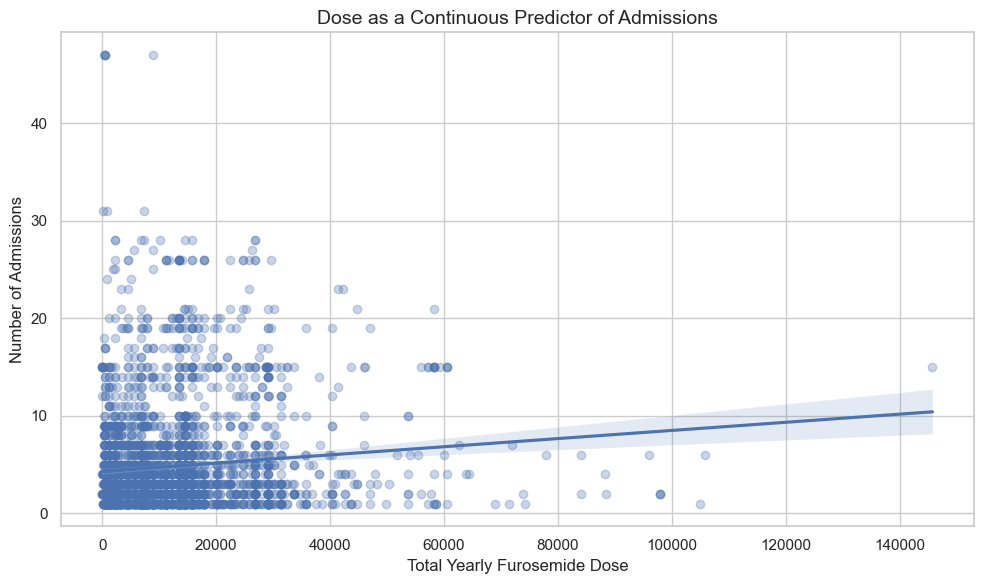

In [2]:
# Load the dataset
file_path = "HF_aligned_data.xlsx"
df = pd.read_excel(file_path)


# Dose as a Continuous Predictor: Regression Plot
# Set plot style 

sns.set(style="whitegrid")

# Regression plot
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Total_Yearly_Dose',
    y='NumAdms',
    data=df,
    scatter_kws={'alpha': 0.3}  # Controls transparency of scatter points
)

# Add titles and labels
plt.title('Dose as a Continuous Predictor of Admissions', fontsize=14)
plt.xlabel('Total Yearly Furosemide Dose')
plt.ylabel('Number of Admissions')

# Show plot
plt.tight_layout()
plt.show()



The scatter plot indicates a weak but positive association between total yearly Furosemide dose and the number of hospital admissions. While higher doses are generally linked with more admissions, the wide spread of data suggests that dose alone does not fully explain admission frequency, pointing to the influence of additional clinical factors e.g., severity of illness, comorbidities.


/var/folders/dr/54f_3qc542jcqd08fgp715200000gn/T/ipykernel_4929/3677455527.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_n = df.pivot_table(index=age_bins, columns=dose_bins,


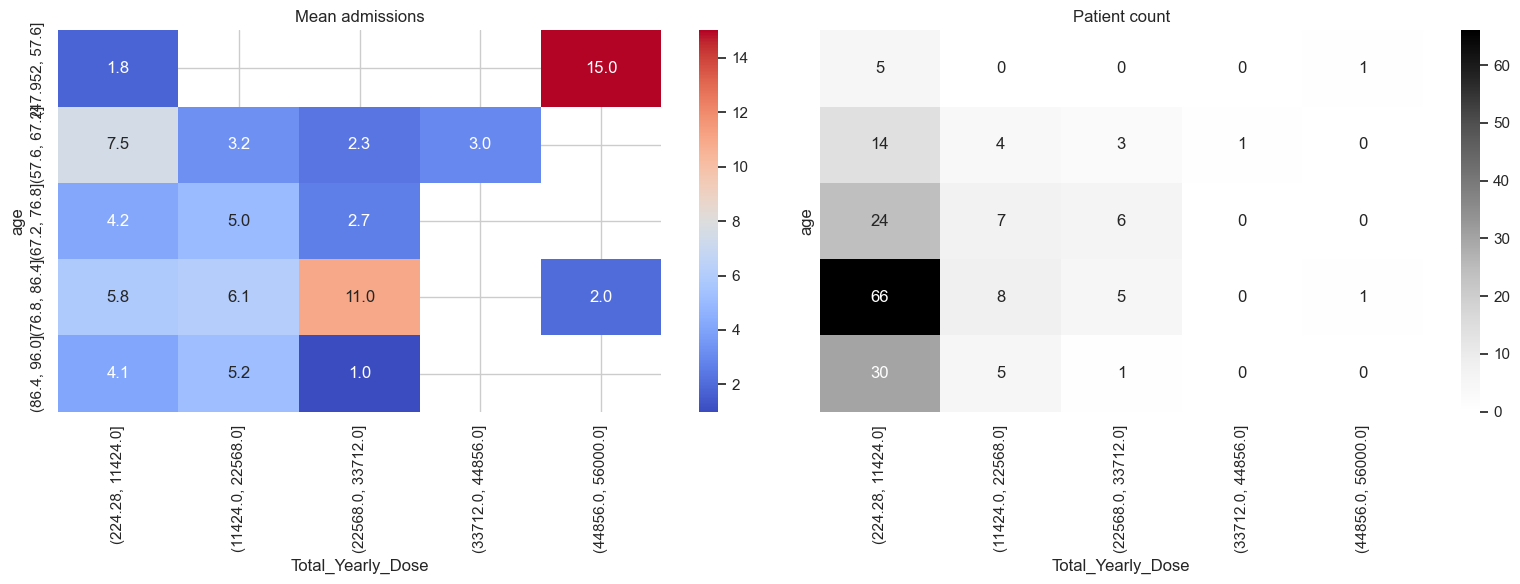

In [31]:
# How many patients in each cell?
pivot_n = df.pivot_table(index=age_bins, columns=dose_bins,
                         values='NumAdms', aggfunc='size')

# Pair the mean heat-map with an N heat-map for context
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='coolwarm', ax=axes[0])
axes[0].set_title('Mean admissions')
sns.heatmap(pivot_n, annot=True, fmt='g', cmap='Greys', ax=axes[1])
axes[1].set_title('Patient count')
plt.tight_layout()
plt.show()


This heatmap shows the distribution of total yearly Furosemide dose across age groups. The most striking finding is the unexpectedly high number of younger patients (40–52 years) receiving the highest dose range, while older age groups show a broader but less intense distribution, possibly reflecting more conservative dosing practices in elderly patients. The 64–76 age group appears to have the most balanced spread across medium and high dose ranges.

- Cell value 15.0 means:
Among all patients aged 40–52 who received a very high annual dose of furosemide, the average number of hospital admissions recorded in NumAdms is 15.

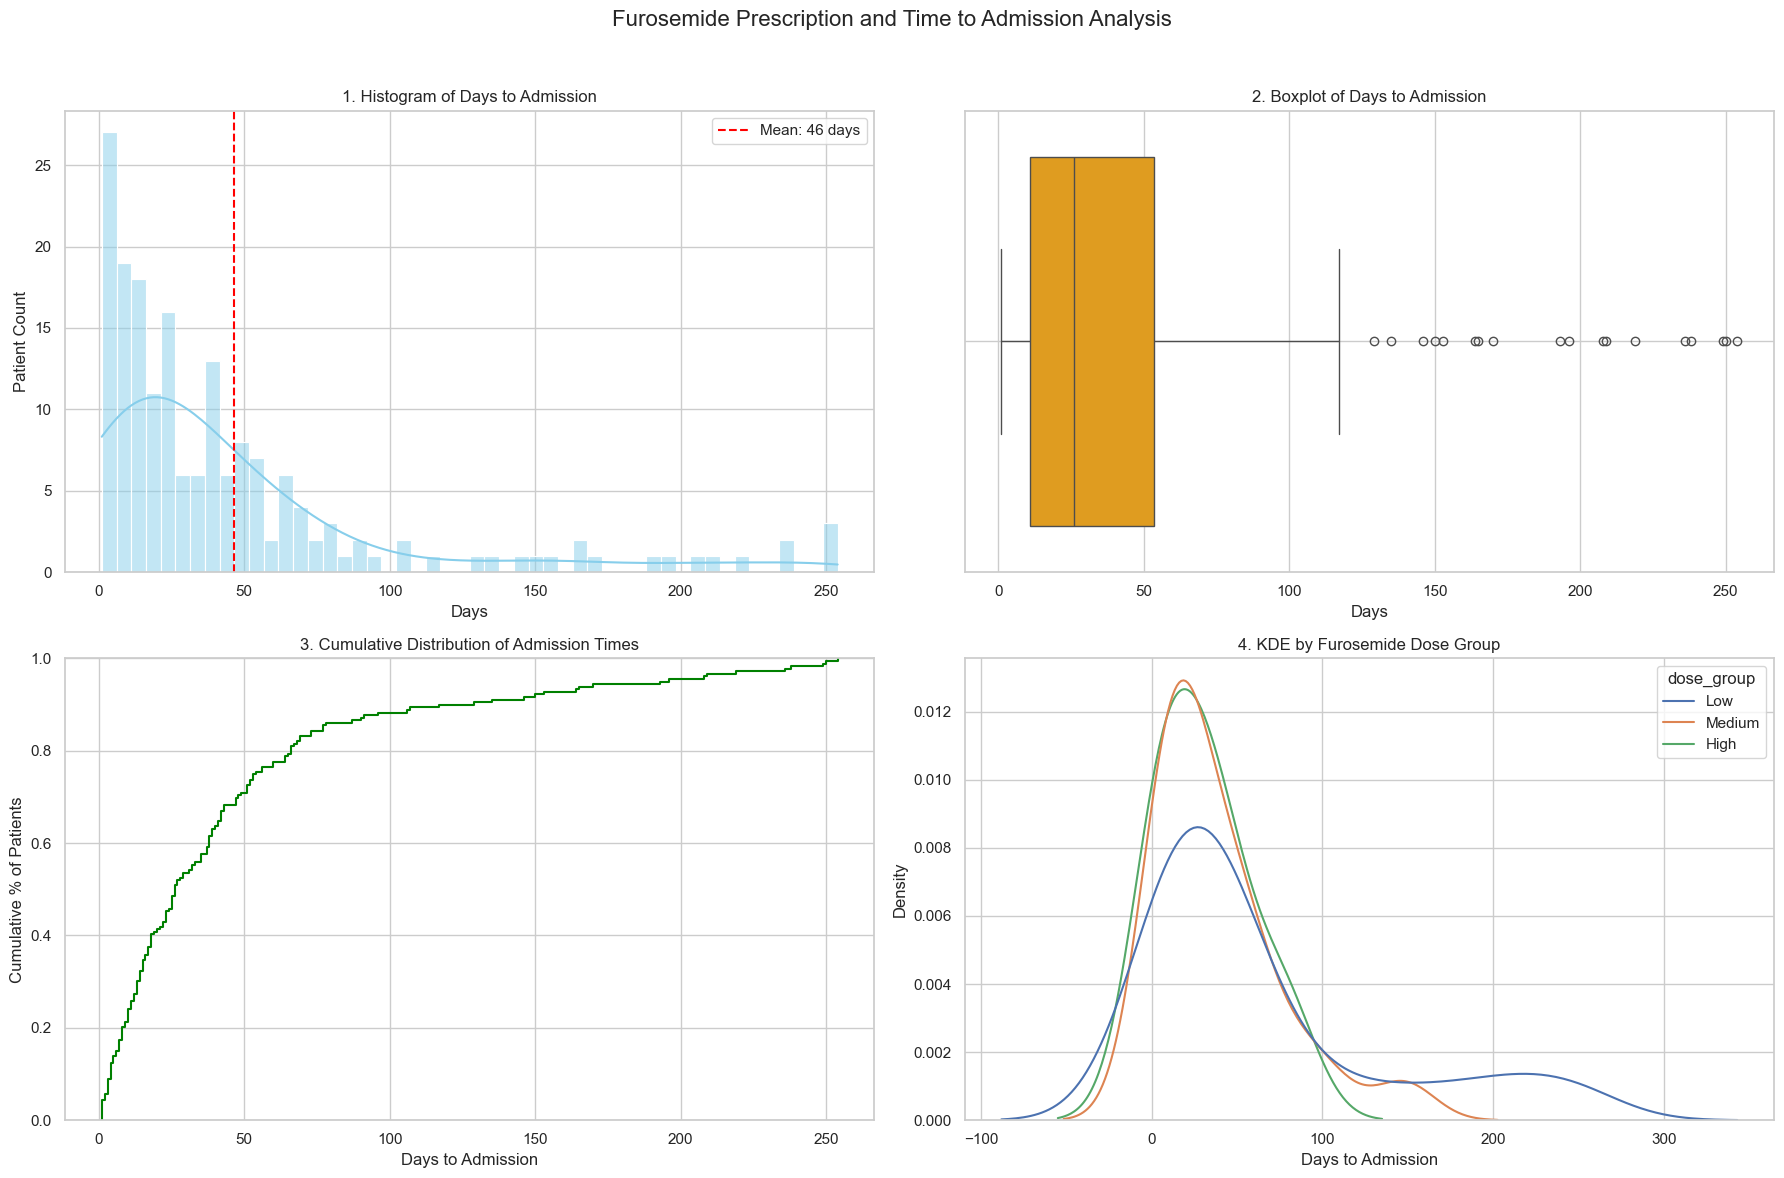

In [92]:
# Visualisation suite to explore time to admission after Furosemide prescription, with summary statistics and stratification by dose.

# 1. Convert date columns
df['date_prescribed'] = pd.to_datetime(df['date_prescribed'], errors='coerce')
df['admitdate'] = pd.to_datetime(df['admitdate'], errors='coerce')

# 2. Calculate time to admission
df['days_to_admission'] = (df['admitdate'] - df['date_prescribed']).dt.days
valid_days = df['days_to_admission'].dropna()
valid_days = valid_days[valid_days > 0]

# 3. Categorize total yearly dose - 
df['dose_group'] = pd.cut(df['Total_Yearly_Dose'], 
                          bins=[0, 3650, 7300, 14600], # up to 40mg/day
                          labels=['Low', 'Medium', 'High'])

# 4. Create dashboard
plt.figure(figsize=(18, 12))

# Histogram + KDE (Kernel Density Estimate)
plt.subplot(2, 2, 1)
sns.histplot(valid_days, bins=50, kde=True, color='skyblue')
plt.axvline(valid_days.mean(), color='red', linestyle='--', label=f'Mean: {valid_days.mean():.0f} days')
plt.title("1. Histogram of Days to Admission")
plt.xlabel("Days")
plt.ylabel("Patient Count")
plt.legend()
plt.grid(True)

# Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(x=valid_days, color='orange')
plt.title("2. Boxplot of Days to Admission")
plt.xlabel("Days")
plt.grid(True)

# ECDF - Empirical Cumulative Distribution Function
plt.subplot(2, 2, 3)
sns.ecdfplot(valid_days, color='green')
plt.title("3. Cumulative Distribution of Admission Times")
plt.xlabel("Days to Admission")
plt.ylabel("Cumulative % of Patients")
plt.grid(True)

# KDE by dose group
plt.subplot(2, 2, 4)
sns.kdeplot(data=df[df['days_to_admission'] > 0], 
            x='days_to_admission', hue='dose_group', common_norm=False)
plt.title("4. KDE by Furosemide Dose Group")
plt.xlabel("Days to Admission")
plt.ylabel("Density")
plt.grid(True)

plt.suptitle("Furosemide Prescription and Time to Admission Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


1. Histogram of Days to Admission

The distribution of time (in days) between Furosemide prescription and hospital admission.
- Key insight: Most patients are admitted within 50 days of prescription, as the distribution is right-skewed (long tail on the right).
- Mean line: The red dashed line indicates the average admission time is 46 days.

Conclusion: Admissions are heavily concentrated early on, but some patients have much longer times to admission.


2. Boxplot of Days to Admission

The spread and outliers of the admission timing.

Conclusion: There’s a lot of variability, with many outliers suggesting a non-normal distribution.


3. Cumulative Distribution Function

The cumulative percentage of patients admitted by a certain number of days.

Key insights:
- Around 50% of patients are admitted within ~30 days
- Around 90% of patients are admitted within ~100 days

Conclusion: The majority of admissions happen relatively early after the prescription, with diminishing returns over time.


4. KDE by Furosemide Dose Group

Smoothed distributions of days to admission, separated by dose groups (Low, Medium, High).

Observations:
- Medium and High doses have sharper peaks around earlier days
- Low dose group has a flatter, wider distribution, indicating more variability and longer admission times

Conclusion: Patients on higher doses of Furosemide tend to be admitted sooner, suggesting dose may correlate with urgency or severity.


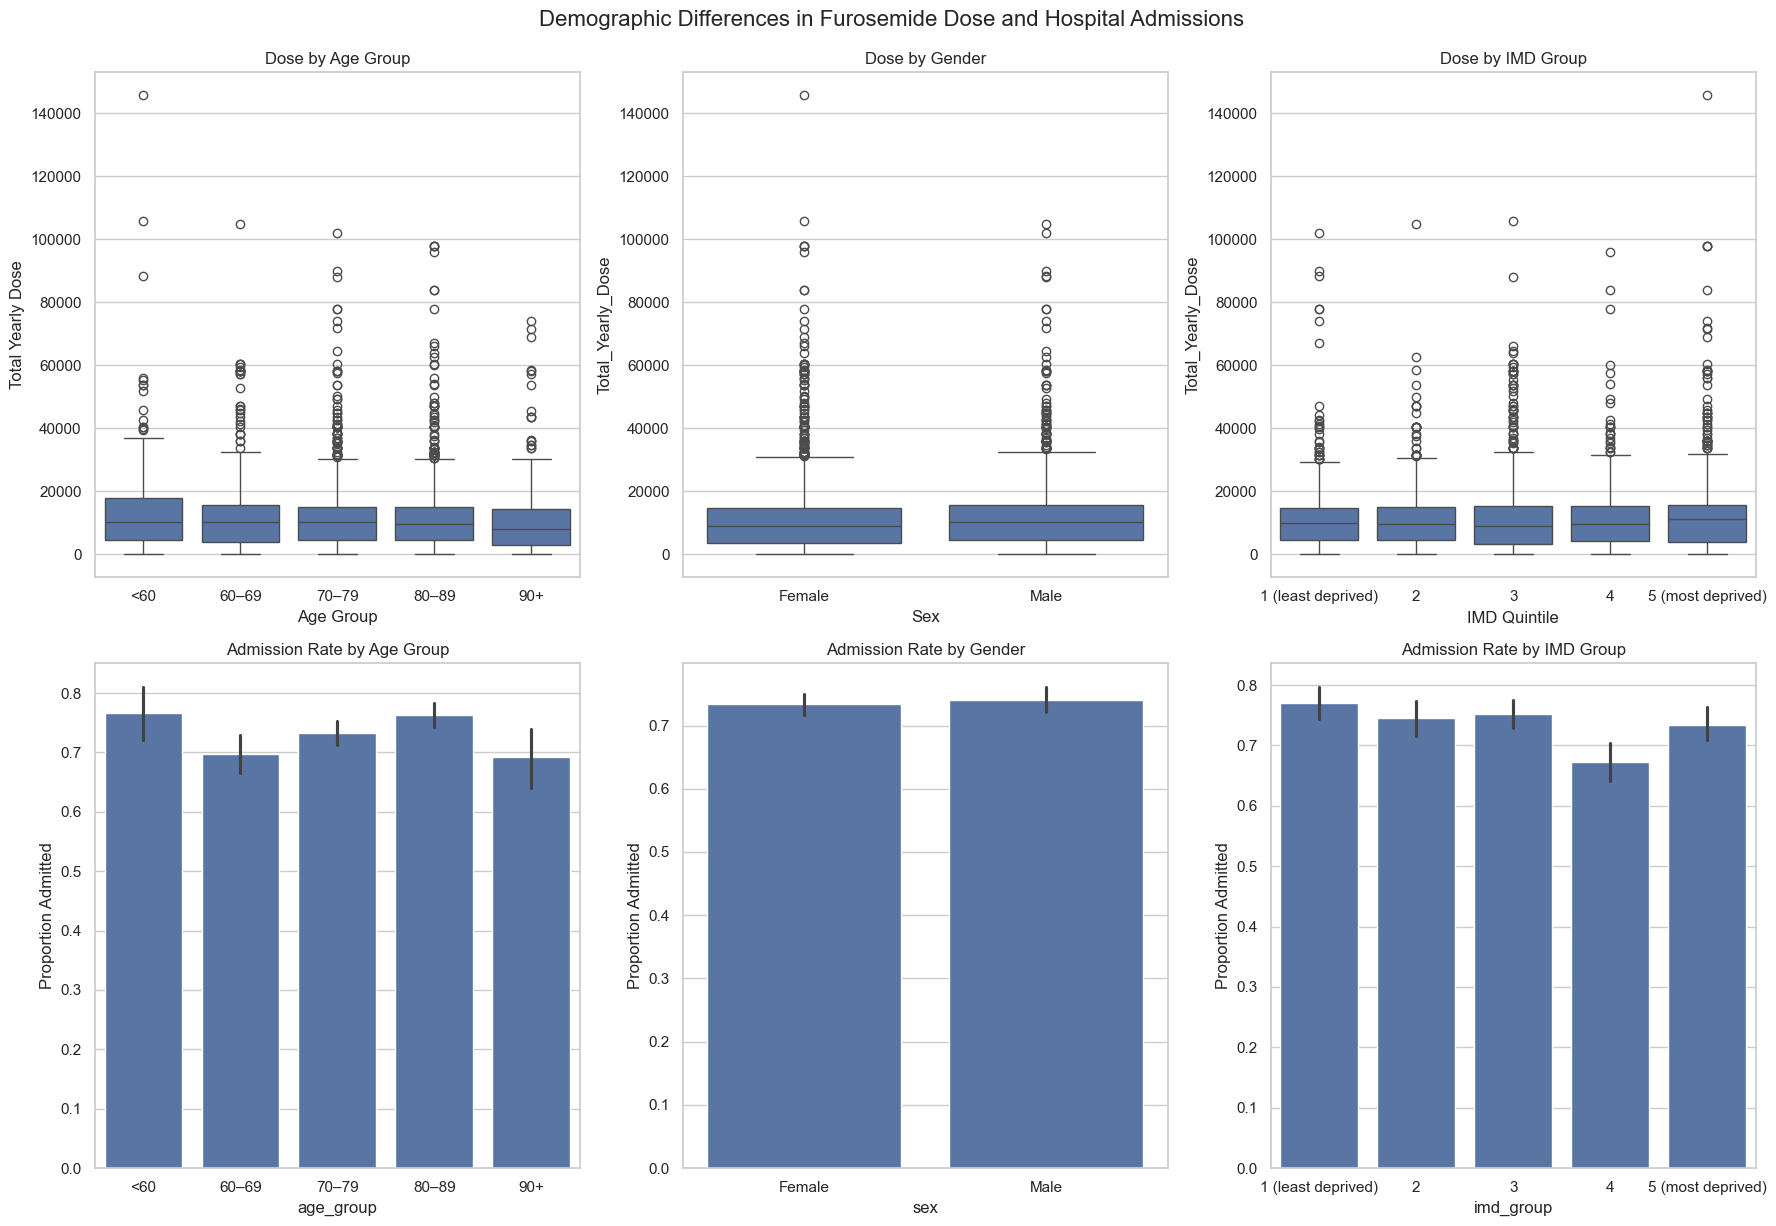

In [98]:
# Preprocessing
df['age'] = pd.to_datetime(df['Indexdate_HFailure']).dt.year - df['birthyear']
df['IMD'] = pd.to_numeric(df['IMD'], errors='coerce')
df['Ever_Admitted'] = df['Ever_Admitted'].replace({'Yes': 1, 'No': 0})
df['Ever_Admitted'] = pd.to_numeric(df['Ever_Admitted'], errors='coerce')

# binning
df['age_group'] = pd.cut(df['age'], bins=[0, 60, 70, 80, 90, 100], labels=['<60', '60–69', '70–79', '80–89', '90+'])
df['imd_group'] = pd.cut(df['IMD'], bins=5, labels=['1 (least deprived)', '2', '3', '4', '5 (most deprived)'])

# Setup figure
plt.figure(figsize=(18, 12))

# Boxplot of Dose by Age Group 
plt.subplot(2, 3, 1)
sns.boxplot(x='age_group', y='Total_Yearly_Dose', data=df)
plt.title("Dose by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Total Yearly Dose")

# Boxplot of Dose by Gender
plt.subplot(2, 3, 2)
sns.boxplot(x='sex', y='Total_Yearly_Dose', data=df)
plt.title("Dose by Gender")
plt.xlabel("Sex")

# Boxplot of Dose by IMD Group
plt.subplot(2, 3, 3)
sns.boxplot(x='imd_group', y='Total_Yearly_Dose', data=df)
plt.title("Dose by IMD Group")
plt.xlabel("IMD Quintile")

# Admission Rate by Age Group
plt.subplot(2, 3, 4)
sns.barplot(x='age_group', y='Ever_Admitted', data=df)
plt.title("Admission Rate by Age Group")
plt.ylabel("Proportion Admitted")

# Admission Rate by Gender
plt.subplot(2, 3, 5)
sns.barplot(x='sex', y='Ever_Admitted', data=df)
plt.title("Admission Rate by Gender")
plt.ylabel("Proportion Admitted")

# Admission Rate by IMD Group
plt.subplot(2, 3, 6)
sns.barplot(x='imd_group', y='Ever_Admitted', data=df)
plt.title("Admission Rate by IMD Group")
plt.ylabel("Proportion Admitted")

plt.tight_layout()
plt.suptitle("Demographic Differences in Furosemide Dose and Hospital Admissions", fontsize=16, y=1.02)
plt.show()


- No obvious dose–admission link by subgroup:
Groups that receive marginally higher doses (e.g., males, most-deprived quintile) do not show markedly higher admission rates. That hints that dose escalation is being used appropriately to keep patients out of hospital, but you’d need patient-level modelling to test that hypothesis.

- Equity lens:
The near-flat admission rates suggest limited demographic inequity in hospitalisation once patients are in the treated cohort. Small dose differences may reflect underlying clinical need rather than access issues.

- Across this cohort, age, sex and deprivation explain little of the variation in either furosemide dose or hospital-admission likelihood. Treatment and outcomes look broadly consistent across demographics, but formal statistical testing and adjustment for clinical severity are essential before drawing firm equity or effectiveness conclusions.


In [113]:
# Age group, IMD group prep (if not already done)
df['age'] = pd.to_datetime(df['Indexdate_HFailure']).dt.year - df['birthyear']
df['age_group'] = pd.cut(df['age'], bins=[0, 60, 70, 80, 90, 100], labels=['<60', '60–69', '70–79', '80–89', '90+'])
df['imd_group'] = pd.cut(df['IMD'], bins=5, labels=['1 (least deprived)', '2', '3', '4', '5 (most deprived)'])

# Ensure 'Ever_Admitted' is numeric
df['Ever_Admitted'] = df['Ever_Admitted'].replace({'Yes': 1, 'No': 0})
df['Ever_Admitted'] = pd.to_numeric(df['Ever_Admitted'], errors='coerce')

# Grouped summary table
summary = df.groupby(['age_group', 'sex', 'imd_group'], observed=False).agg(
    Mean_Dose=('Total_Yearly_Dose', 'mean'),
    Mean_NumAdms=('NumAdms', 'mean'),
    Admission_Rate=('Ever_Admitted', 'mean'),
    Mean_Comorbidities=('NumberofComobidites', 'mean'),
    Count=('patID', 'count')
).reset_index()

summary = summary.round(2)

summary.style.set_caption("Summary Table by Age Group, Sex, and IMD Group") \
              .format(precision=2) \
              .background_gradient(cmap="Blues", subset=["Mean_Dose", "Admission_Rate"])



,age_group,sex,imd_group,Mean_Dose,Mean_NumAdms,Admission_Rate,Mean_Comorbidities,Count
0,<60,Female,1 (least deprived),7280.00,4.00,0.50,3.88,8
1,<60,Female,2,14707.00,4.68,0.95,6.10,20
2,<60,Female,3,15496.92,5.73,0.77,7.05,39
3,<60,Female,4,7962.29,3.71,0.49,4.83,35
4,<60,Female,5 (most deprived),16336.15,7.91,0.90,6.97,78
5,<60,Male,1 (least deprived),17170.32,4.33,0.58,5.87,31
6,<60,Male,2,12434.07,14.89,0.67,7.30,27
7,<60,Male,3,14906.67,3.94,0.89,5.75,36
8,<60,Male,4,10078.86,2.59,0.91,6.54,35
9,<60,Male,5 (most deprived),12889.41,7.10,0.59,5.53,17


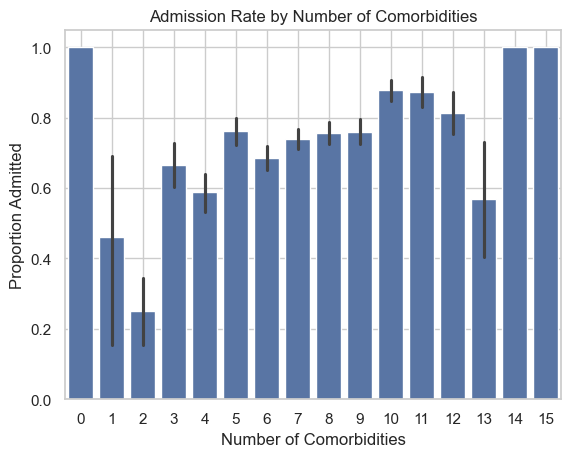

In [103]:
# Barplot: Admissions by Number of Comorbidities
sns.barplot(x='NumberofComobidites', y='Ever_Admitted', data=df)
plt.title("Admission Rate by Number of Comorbidities")
plt.xlabel("Number of Comorbidities")
plt.ylabel("Proportion Admitted")
plt.grid(True)
plt.show()


This chart shows that hospital admission rates generally increase with the number of comorbidities, particularly from 5 conditions onward. Patients with no comorbidities or many (14–15) appear to have very high admission rates, though the error bars suggest the sample size for those extremes may be small. The trend suggests a strong relationship between comorbidity burden and the likelihood of admission.

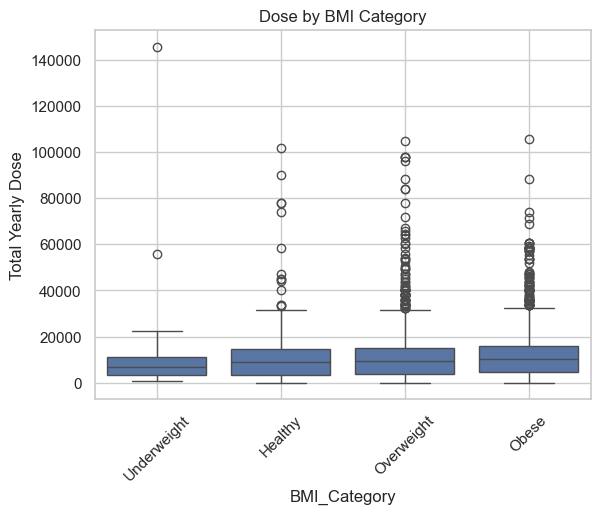

In [107]:
# Dose by BMI Category
# Define the desired order
bmi_order = ["Underweight", "Healthy", "Overweight", "Obese"]

# Plot with custom order
sns.boxplot(x='BMI_Category', y='Total_Yearly_Dose', data=df, order=bmi_order)
plt.title("Dose by BMI Category")
plt.xticks(rotation=45)
plt.ylabel("Total Yearly Dose")
plt.grid(True)
plt.show()


There is no major difference in total yearly dose across BMI categories. The medians and IQRs are fairly consistent. While the obese group shows a slightly wider spread and more extreme outliers, the central tendency is relatively stable across groups. This suggests that BMI category may not strongly influence the total medication dose in this population.

- Comorbidities appear to be a stronger driver of admission risk than BMI is of dose differences. This could guide targeting of interventions toward patients with high comorbidity counts, regardless of BMI.